In [ ]:
import os, sys, random, shutil
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import cv2

In [ ]:
df = []
cnt = 0

annotations = sorted(glob('/content/drive/MyDrive/tobacco_data_zhugy/groundtruth/*.xml'))
for file in annotations:
    myroot = ET.parse(file).getroot()
    prev_filename = myroot[0].attrib['src']
    filename = str(cnt) + '.tif' 
    page_height, page_width =  myroot[0][0].attrib['height'], myroot[0][0].attrib['width']
    
    row = []
    for zone in myroot[0][0]:
        category = zone.attrib['gedi_type'] 
        id = zone.attrib['id']
        x, y = zone.attrib['col'], zone.attrib['row'] 
        w, h = zone.attrib['width'], zone.attrib['height'] 
        
        if category == 'DLSignature':
            AuthorID = zone.attrib['AuthorID']
            Overlapped = zone.attrib['Overlapped']
        else:
            AuthorID, Overlapped = ('NA', 'NA')
        row = [prev_filename, filename, page_height, page_width, AuthorID, Overlapped, category, id, x, y, w, h]
        df.append(row)
    cnt += 1

In [ ]:
data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'page_height', 'page_width', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height'])
data

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110
...,...,...,...,...,...,...,...,...,...,...,...,...
1337,zrz94a00-page02_1.tif,1284.tif,2156,1728,NA,NA,DLLogo,None,737,116,191,124
1338,zrz94a00-page02_2.tif,1285.tif,2156,1728,"Dimech, Ellen",Yes,DLSignature,None,828,1046,362,91
1339,zss86d00.tif,1286.tif,2292,1728,"Nielsen, Vigo G.",Yes,DLSignature,None,867,1734,363,189
1340,ztz52d00-page02_2.tif,1288.tif,2292,1728,"Bergman, J.I.",Yes,DLSignature,None,896,651,205,178


In [ ]:
test = data[['page_height', 'page_width']]
test.max(), test.min()

(page_height    3584.0
 page_width     2720.0
 dtype: float64, page_height    1575.0
 page_width     1200.0
 dtype: float64)

In [ ]:
BASE_DIR = '/content/drive/MyDrive/tobacco_data_zhugy/pages/'
SAVE_PATH = '/content/drive/MyDrive/tobacco_data_zhugy/scaled/'
os.mkdir(SAVE_PATH)

def scale_image(df):
    df_new = []
    filename = df.prev_filename
    X, Y, W, H = map(int, df.x), map(int, df.y), map(int, df.width), map(int, df.height)
    for file, x, y, w, h in zip(filename, X, Y, W, H):
        image_path = BASE_DIR + file
        img = cv2.imread(image_path, 1)
        page_height, page_width = img.shape[:2]
        max_height = 640
        max_width = 480
        
        if max_height < page_height or max_width < page_width:
            scaling_factor = max_height / float(page_height)
            if max_width/float(page_width) < scaling_factor:
                scaling_factor = max_width / float(page_width)
            img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
        jpg_filename = file[:-4] + '.jpg'
        new_file_path = SAVE_PATH + jpg_filename
        cv2.imwrite(new_file_path, img) 
        
        
        page_height, page_width = page_height*scaling_factor, page_width*scaling_factor
        
        x, y, w, h= int(x*scaling_factor), int(y*scaling_factor), int(w*scaling_factor), int(h*scaling_factor)
        row = [jpg_filename, x, y, w, h, page_height, page_width]
        df_new.append(row)
    return df_new
scaled_data = scale_image(data)

In [ ]:
scaled_data = list(zip(*scaled_data))

data['new_filename'] = scaled_data[0]
data['x_scaled'] = scaled_data[1]
data['y_scaled'] = scaled_data[2]
data['w_scaled'] = scaled_data[3]
data['h_scaled'] = scaled_data[4]
data['page_height_scaled'] = scaled_data[5]
data['page_width_scaled'] = scaled_data[6]
data.head(10)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618.000000,480.0
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636.666667,480.0
5,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181,acr64d00.jpg,246,500,128,50,636.666667,480.0
6,adh36e00-page2_1.tif,7.tif,3245,2560,NA,NA,DLLogo,None,1181,18,359,219,adh36e00-page2_1.jpg,221,3,67,41,608.437500,480.0
7,adh36e00-page2_2.tif,8.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1232,2399,896,431,adh36e00-page2_2.jpg,231,449,168,80,608.625000,480.0
8,adh36e00_1.tif,9.tif,3245,2560,NA,NA,DLLogo,None,1187,18,347,219,adh36e00_1.jpg,222,3,65,41,608.437500,480.0
9,adh36e00_2.tif,10.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1239,2403,889,434,adh36e00_2.jpg,232,450,166,81,608.625000,480.0


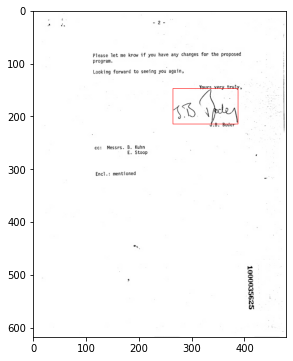

In [ ]:
img = cv2.imread('/content/drive/MyDrive/tobacco_data_zhugy/scaled/aah97e00-page02_2.jpg')

img = cv2.rectangle(img, (264, 148), (123+264, 67+148), (255, 0, 0), 1)
plt.figure(figsize=(6, 6))
plt.imshow(img)

In [ ]:
data[['prev_filename', 'new_filename', 'filename', 'page_height', 'page_width', 'page_height_scaled', 'page_width_scaled', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height', 'x_scaled', 'y_scaled', 'w_scaled', 'h_scaled']].to_csv('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_cleaned.csv', index=False)
data.head(3)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618.000000,480.0
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0


In [ ]:
len(data)

1342

In [ ]:
def x_center(df):
  return int(df.x_scaled + (df.w_scaled/2))
def y_center(df):
  return int(df.y_scaled + (df.h_scaled/2))

def w_norm(df, col):
  return df[col]/df['page_width_scaled']
def h_norm(df, col):
  return df[col]/df['page_height_scaled']

df = pd.read_csv('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_cleaned.csv')

le = preprocessing.LabelEncoder()
le.fit(df['category'])
print(le.classes_)
labels = le.transform(df['category'])
df['labels'] = labels


df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df.apply(w_norm, col='x_center',axis=1)
df['width_norm'] = df.apply(w_norm, col='w_scaled', axis=1)

df['y_center_norm'] = df.apply(h_norm, col='y_center',axis=1)
df['height_norm'] = df.apply(h_norm, col='h_scaled',axis=1)

df.head(2)


['DLLogo' 'DLSignature']


,prev_filename,new_filename,filename,page_height,page_width,page_height_scaled,page_width_scaled,AuthorID,Overlapped,category,id,x,y,width,height,x_scaled,y_scaled,w_scaled,h_scaled,labels,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,aah97e00-page02_1.tif,aah97e00-page02_1.jpg,0.tif,3296,2560,618.0,480.0,NaN,NaN,DLLogo,None,1074,18,374,219,201,3,70,41,0,236,23,0.491667,0.145833,0.037217,0.066343
1,aah97e00-page02_2.tif,aah97e00-page02_2.jpg,1.tif,3296,2560,618.0,480.0,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,264,148,123,67,1,325,181,0.677083,0.256250,0.292880,0.108414


In [ ]:
len(df)

1342

In [ ]:
df = df.loc[df['category'] == "DLSignature"]

In [ ]:
# df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
# print(df_train.shape, df_valid.shape)

In [ ]:
os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/')
os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/images/')
# os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/train/')
# os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/valid/')

os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/labels/')
# os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/labels/train/')
# os.mkdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/valid/')

In [ ]:
def segregate_data(df, img_path, label_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.new_filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and validation folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.new_filename), os.path.join(train_img_path,row.new_filename))
 
# Apply function
src_img_path = "/content/drive/MyDrive/tobacco_data_zhugy/scaled/"
src_label_path = "/content/drive/MyDrive/tobacco_data_zhugy/groundtruth/"

train_img_path = "/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/images/"
train_label_path = "/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/labels/"

# valid_img_path = "/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/images/valid"
# valid_label_path = "/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/labels/valid"

# segregate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
segregate_data(df, src_img_path, src_label_path, train_img_path, train_label_path)

#segregate_data(df_valid, src_img_path, src_label_path, valid_img_path, valid_label_path)

# print("No. of Training images", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/train')))
# print("No. of Training labels", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/train')))

# print("No. of valid images", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/images/valid')))
# print("No. of valid labels", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format/labels/valid')))

In [ ]:
print("No. of Training images", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/images/')))
print("No. of Training labels", len(os.listdir('/content/drive/MyDrive/tobacco_data_zhugy/tobacco_yolo_format1/labels/')))


No. of Training images 776
No. of Training labels 776
